In [10]:
# --- Carregando e limpando os dados (sabemos que esta parte funciona) ---
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

ticker = 'UUUU'
df = pd.read_csv(f'../data/raw/{ticker}_raw.csv', index_col=0, parse_dates=True)

cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)


/var/folders/bc/3fck38_57j918mwlyxrxlxnh0000gn/T/ipykernel_27656/3209722499.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'../data/raw/{ticker}_raw.csv', index_col=0, parse_dates=True)


In [11]:
# --- Resetando o índice e INVESTIGANDO os nomes das colunas ---
df_prophet = df.reset_index()

print("Nomes das colunas APÓS o reset_index():")
print(df_prophet.columns)

Nomes das colunas APÓS o reset_index():
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [12]:

# Resetamos o índice, o que cria a coluna 'Price'
df_prophet = df.reset_index()

# Agora, renomeamos a coluna 'Price' (que contém as datas) para 'ds'
df_prophet = df_prophet.rename(columns={'Price': 'ds', 'Close': 'y'})

# Selecionamos apenas as duas colunas que o Prophet precisa
df_prophet = df_prophet[['ds', 'y']]

print("DataFrame preparado com sucesso para o Prophet!")
display(df_prophet.head())

DataFrame preparado com sucesso para o Prophet!


,ds,y
0,2015-01-02,6.16
1,2015-01-05,5.33
2,2015-01-06,5.31
3,2015-01-07,5.39
4,2015-01-08,5.32


In [13]:
# Assim como no modelo ARIMA, a divisão deve ser cronológica.
# Vamos usar a mesma data de corte para uma comparação justa.
train_prophet = df_prophet[df_prophet['ds'] <= '2023-12-31']
test_prophet = df_prophet[df_prophet['ds'] > '2023-12-31']

print(f"Tamanho do conjunto de treino: {len(train_prophet)} dias")
print(f"Tamanho do conjunto de teste: {len(test_prophet)} dias")


# --- Passagem 2: Instanciando e Treinando o Modelo ---
# Criamos uma 'instância' do modelo Prophet.
# Por padrão, ele já vem configurado para encontrar tendências e sazonalidades.
model_prophet = Prophet()

# Este é o comando de treinamento. O Prophet aprende os padrões dos dados de treino.
print("\nTreinando o modelo Prophet...")
model_prophet.fit(train_prophet)
print("Treinamento concluído!")


# --- Passagem 3: Criando o DataFrame Futuro ---
# O Prophet precisa de um DataFrame com as datas futuras que queremos prever.
# 'periods' é o número de dias no futuro.
# 'freq='B'' significa Business day (dias úteis), o que é ideal para ações.
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='B')


# --- Passagem 4: Fazendo a Previsão ---
# O comando .predict() usa o modelo treinado para preencher o DataFrame futuro.
forecast = model_prophet.predict(future)


# --- Passagem 5: Inspecionando a Previsão ---
# O resultado 'forecast' é uma tabela com muitas colunas.
# As mais importantes são:
# 'ds': a data
# 'yhat': a previsão do preço
# 'yhat_lower' e 'yhat_upper': o intervalo de confiança da previsão
print("\nÚltimos 5 dias da previsão:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

22:30:36 - cmdstanpy - INFO - Chain [1] start processing


Tamanho do conjunto de treino: 2264 dias
Tamanho do conjunto de teste: 449 dias

Treinando o modelo Prophet...


22:30:37 - cmdstanpy - INFO - Chain [1] done processing


Treinamento concluído!

Últimos 5 dias da previsão:


,ds,yhat,yhat_lower,yhat_upper
2708,2025-09-12,5.941100,2.908393,8.989051
2709,2025-09-15,5.953447,3.136589,9.179985
2710,2025-09-16,5.941117,2.940037,9.107297
2711,2025-09-17,5.932350,2.990194,9.308671
2712,2025-09-18,5.918560,2.967704,9.058023


/var/folders/bc/3fck38_57j918mwlyxrxlxnh0000gn/T/ipykernel_27656/3718048204.py:10: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(test_prophet['ds'], test_prophet['y'], color='orange', linestyle='--', label='Preço Real (Teste)')


ConversionError: Failed to convert value(s) to axis units: array(['2015-01-02T00:00:00.000000000', '2015-01-05T00:00:00.000000000',
       '2015-01-06T00:00:00.000000000', ...,
       '2023-12-27T00:00:00.000000000', '2023-12-28T00:00:00.000000000',
       '2023-12-29T00:00:00.000000000'],
      shape=(2264,), dtype='datetime64[ns]')

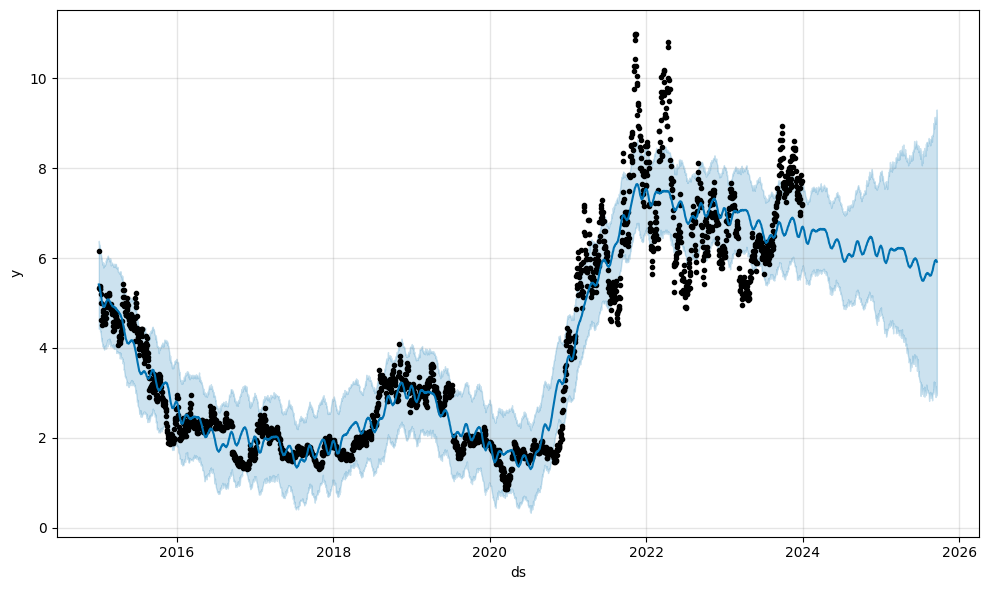

In [19]:
# --- Passagem 1: Plotando a previsão do Prophet e CAPTURANDO o eixo ---
# O método .plot() retorna a figura do matplotlib.
fig1 = model_prophet.plot(forecast)

# Usamos .gca() (Get Current Axes) para pegar o eixo específico que o Prophet desenhou.
ax = fig1.gca()

# --- Passagem 2: Adicionando o preço real AO EIXO CAPTURADO ---
# Agora, em vez de plt.plot(), usamos ax.plot()
ax.plot(test_prophet['ds'], test_prophet['y'], color='orange', linestyle='--', label='Preço Real (Teste)')

# --- Passagem 3: Customizando o Gráfico no Eixo ---
ax.set_title('Previsão Prophet vs. Preço Real - UUUU')
ax.set_xlabel('Data')
ax.set_ylabel('Preço de Fechamento (USD)')
ax.legend()

plt.show()


22:42:54 - cmdstanpy - INFO - Chain [1] start processing


Treinando o modelo Prophet...


22:42:55 - cmdstanpy - INFO - Chain [1] done processing


Treinamento concluído!


/var/folders/bc/3fck38_57j918mwlyxrxlxnh0000gn/T/ipykernel_27656/1735112962.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])


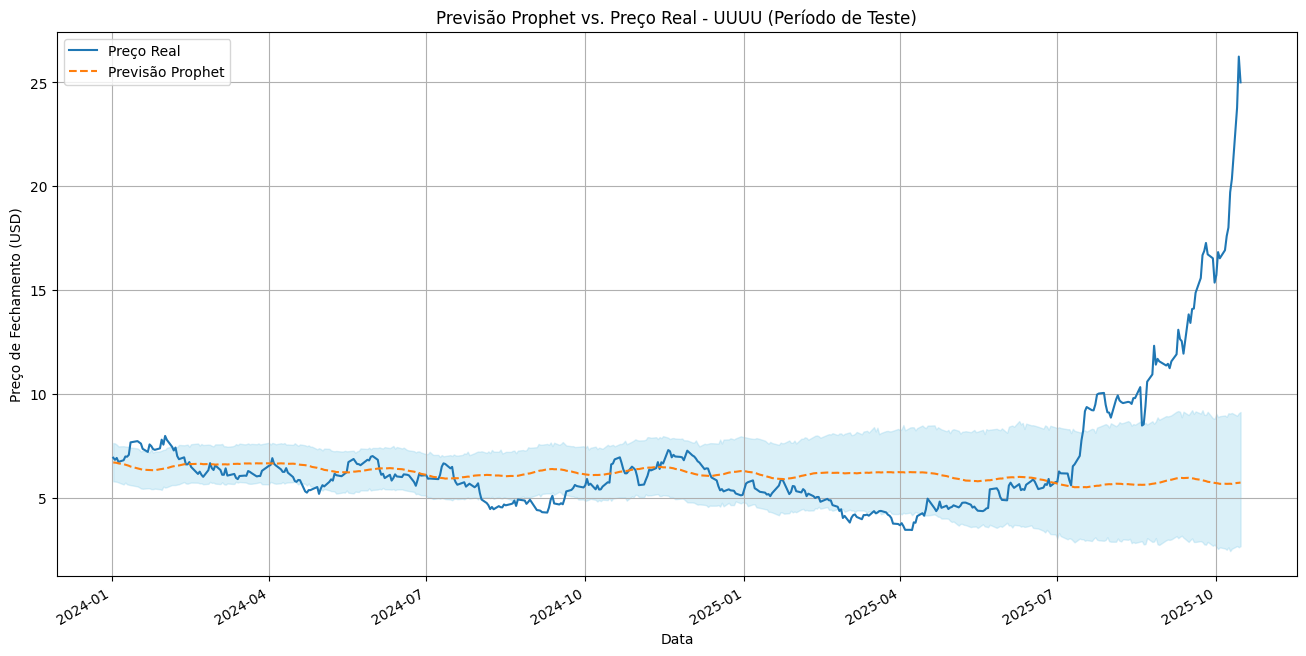

In [25]:
# --- Passagem 1 e 2: Treinamento (sem alteração) ---
train_prophet = df_prophet[df_prophet['ds'] <= '2023-12-31']
test_prophet = df_prophet[df_prophet['ds'] > '2023-12-31']

model_prophet = Prophet()
print("Treinando o modelo Prophet...")
model_prophet.fit(train_prophet)
print("Treinamento concluído!")

# --- Passagem 3: Previsão (sem alteração) ---
forecast = model_prophet.predict(test_prophet)

# --- Passagem 4 (NOVA): Garantindo a compatibilidade de tipos ---
# Esta função é como um "tradutor" que garante que ambas as colunas de data
# sejam entendidas pelo pandas da mesma forma.
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])


# --- Passagem 5: Combinando os DataFrames (agora deve funcionar) ---
comparison_df = pd.merge(test_prophet, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
comparison_df = comparison_df.set_index('ds')


# --- Passagem 6: Plotando a partir do DataFrame combinado ---
fig, ax = plt.subplots(figsize=(16, 8))

comparison_df[['y', 'yhat']].plot(ax=ax, style=['-', '--'])

ax.fill_between(comparison_df.index, 
                comparison_df['yhat_lower'], 
                comparison_df['yhat_upper'], 
                color='skyblue', alpha=0.3)

ax.set_title('Previsão Prophet vs. Preço Real - UUUU (Período de Teste)')
ax.set_xlabel('Data')
ax.set_ylabel('Preço de Fechamento (USD)')
ax.legend(['Preço Real', 'Previsão Prophet'])
plt.grid(True)
plt.show()

In [26]:
# --- Passagem 1: Importando as métricas ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Passagem 2: Juntando os dataframes para garantir o alinhamento ---
# Usamos o mesmo método robusto que usamos para o gráfico
comparison_df = pd.merge(test_prophet, forecast[['ds', 'yhat']], on='ds')

# --- Passagem 3: Calculando os erros ---
# Comparamos a coluna real 'y' com a coluna prevista 'yhat'
mae_prophet = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))

# --- Passagem 4: Exibindo os resultados ---
print("="*50)
print("Avaliação do Modelo Prophet")
print(f"Mean Absolute Error (MAE): {mae_prophet:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet:.4f}")
print("="*50)

Avaliação do Modelo Prophet
Mean Absolute Error (MAE): 1.7524
Root Mean Squared Error (RMSE): 3.2650
